In [1]:
import torch
import random
import numpy as np
from collections import deque
from game import SnakeGameAI, Direction, Point
from model import Linear_QNet, QTrainer
from helper import plot
import pygame


import math, random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import keyboard

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


game = SnakeGameAI()

move = [1,1,1]
reward, game_over, score, array3D = game.play_step(move)


# RUN THIS IF YOU WANT TO UNDERSTAND ONLY
game = SnakeGameAI()
move = [0,0,0]
while True:
  
    reward, game_over, score,array3D = game.play_step(move)

    time.sleep(1)
    if game_over == True:
        break

print('Final Score', score)
pygame.display.quit() 
pygame.quit()
    

(180, 120, 3)
(120, 180, 3)


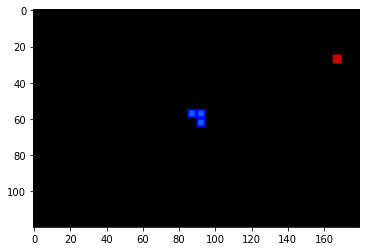

In [21]:
array3D
print(array3D.shape)

v = array3D.transpose((1,0,2))
print(v.shape)

plt.imshow(v)

In [11]:
# RUN THIS ONLY IF YOU WANT TO CLOSE THE PYGAME WINDOW
pygame.display.quit() 
pygame.quit()



if __name__ == '__main__':
    train()

In [2]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [ ]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    #state      = Variable(torch.FloatTensor(np.float32(state)))
    #next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    #action     = Variable(torch.LongTensor(action))
    #reward     = Variable(torch.FloatTensor(reward))
    #done       = Variable(torch.FloatTensor(done))

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [3]:
class CnnDQN(nn.Module):
    def __init__(self, channels_in, num_actions):
        super(CnnDQN, self).__init__()
        
        self.channels_in = channels_in
        self.num_actions = num_actions
        self.feature_size = 1152
        
        self.features = nn.Sequential(
            nn.Conv2d(channels_in, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride = 3)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        
       
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    

def act(state, epsilon):
        if random.random() > epsilon:
            #state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            n = random.randrange(self.num_actions)
            action = random.randrange(env.action_space.n)
        return action

In [4]:
#Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

# Not needed anymore - Outdated, can straight find loss and backward pass
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [5]:
channels_input = 3
num_actions = 3
model = CnnDQN(channels_input, num_actions).to(device) # (210, 160, 3) , (6)

lr = 1e-5
    
optimizer = optim.Adam(model.parameters(), lr=lr)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

# Frame:
start = 1
total_frames = 2

# start:
game = SnakeGameAI()

In [6]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)


In [ ]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

In [7]:

episode_reward = 0
out = 0

#game = SnakeGameAI()
move = np.zeros(3).astype(np.int)
move = move.tolist()
_, _, _, array3D = game.play_step(move) # No.0
for curr_frame in range(start, total_frames):
    # later all this will be move into train_epoch function
    state = torch.tensor(array3D.transpose((2,1,0))).unsqueeze(0) # Getting image in 4D Tensor
    #print(state.shape)
    
    model.train()    # Start training
    move = np.zeros(3).astype(np.int)
    
    
    epsilon = epsilon_by_frame(curr_frame) # No. 1
    if random.random() > epsilon:
        #state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
        state = state.float()
        q_value = model(state.to(device))
        action  = q_value.max(1)[1].data[0]
    else:
        action = random.randrange(num_actions)

    move[action] = 1
    move = move.tolist()
    
    reward, game_over, score, array3D = game.play_step(move) # No.2
    next_state = torch.tensor(array3D.transpose((2,1,0))).unsqueeze(0) # Getting image in 4D Tensor
    
    state = next_state
    episode_reward += reward
    
    # Continue .... if game_over:.....
    
    # hold while waiting your command:
    out = input()
    if (int(out) == 1):
        break
game.reset()
print('Final Score', score)
pygame.display.quit() 
pygame.quit()

1
Final Score 0


In [22]:
state = state.float()
q_value = model(state.to(device))
action  = q_value.max(1)[1].data[0]

mv = np.zeros(3).astype(int)
mv[action] = 1
mv = mv.tolist()
print(mv)

print(state.shape, next_state.shape)

[0, 1, 0]
torch.Size([1, 3, 120, 180]) torch.Size([1, 3, 120, 180])


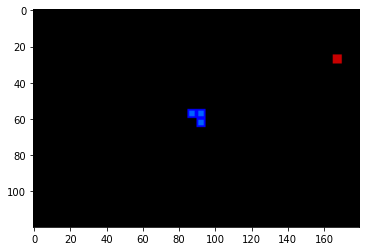

In [27]:
m = nn.Softmax(dim=1)
m(q_value)

img = state.cpu().detach().numpy()
img = img.squeeze(0).transpose((1,2,0))
plt.imshow(img/255)

In [ ]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset() # No.0
# No.0 - play 1st frame
# No.1 - get action from CNN
# No.2 insert action into the game - get all things -> next state
# No.3 push into buffer
# No.4 current is next state

for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx) 
    action = model.act(state, epsilon) # No.1 - state & epsilon(random) to get action (random or learnt)
    
    next_state, reward, done, _ = env.step(action) # No.2
    replay_buffer.push(state, action, reward, next_state, done) # No.3
    
    state = next_state # No.4
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)